<a href="https://colab.research.google.com/github/anna-marshalova/ai-generated-essays-detection/blob/1-dataset-collection-and-EDA/llm_detect_ai_generated_text_EDA_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some preparations

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List
from copy import deepcopy
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

# Loading data

## Loading original dataset

In [11]:
! pip install -q kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [12]:
!kaggle competitions download -c llm-detect-ai-generated-text
!unzip /content/llm-detect-ai-generated-text.zip -d competition_data

  0% 0.00/1.38M [00:00<?, ?B/s]
100% 1.38M/1.38M [00:00<00:00, 50.8MB/s]
Archive:  /content/llm-detect-ai-generated-text.zip
  inflating: competition_data/sample_submission.csv  
  inflating: competition_data/test_essays.csv  
  inflating: competition_data/train_essays.csv  
  inflating: competition_data/train_prompts.csv  


In [13]:
TRAIN_DATA_PATH = '/content/competition_data/train_essays.csv'
original_df = pd.read_csv(TRAIN_DATA_PATH)
original_df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [93]:
print(f'Размер датасета:{len(original_df)}')

Размер датасета:1378


### Target distribution

In [94]:
original_df.groupby('generated').agg({'id':'count'})

,id
generated,
0,1375
1,3


Сгенерированных текста всего 3....

In [95]:
original_df[original_df.generated == 1]

,id,prompt_id,text,generated,source,len
704,82131f68,1,"This essay will analyze, discuss and prove one...",1,original,235
740,86fe4f18,1,I strongly believe that the Electoral College ...,1,original,258
1262,eafb8a56,0,"Limiting car use causes pollution, increases c...",1,original,289


In [96]:
original_df.loc[704].text

"This essay will analyze, discuss and prove one reason in favor of keeping the Electoral College in the United States for its presidential elections. One of the reasons to keep the electoral college is that it is better for smaller, more rural states to have more influence as opposed to larger metropolitan areas that have large populations. The electors from these states are granted two votes each. Those from larger, more populated areas are granted just one vote each. Smaller states tend to hold significant power because their two votes for president and vice president add up more than the votes of larger states that have many electors. This is because of the split of the electoral votes. Some argue that electors are not bound to vote for the candidate who won the most votes nationally. They do not have to vote for their own state's nominee unless their state has a winner take all system. However, there are states that have adopted laws that force their electors to vote for their stat

In [97]:
original_df.loc[740].text

"I strongly believe that the Electoral College should remain the way it is or, better yet, that we should elect the president by popular vote. This is due to the fact that the Electoral College does not accurately reflect the will of the people. For example, in the 2016 presidential election, an estimated two million more people voted for Hillary Clinton than for Donald Trump however, Trump won the Electoral College vote, 304 to 232. This means that a candidate can win a majority of the Electoral College voters while losing the popular vote! Furthermore, voting for President should be an individual citizen decision, not a state decision. The Electoral College works by awarding all of a state's electoral votes to the winner of the majority of votes in the state. This means that a candidate can win the majority of votes in a state and still not receive any of that states electoral votes. This goes against the concept of onepersononevote, since a candidate can win the majority of votes in

In [98]:
original_df.loc[1262].text

"Limiting car use causes pollution, increases costs to users regardless of where services or services are offered. Furthermore, over use of the gas results in increased environmental degradation, harming our resources while damaging our environment.\n\nWhen consumers pay a larger amount before gasoline is refined then there are higher costs of running the engine than otherwise. There are fewer places where the gas can be purchased locally causing more problems. Car trips will usually have higher tolls which results in lost wages for the transportation worker, who goes to an unnecessary location for work and then returns home and gets to pay back his transportation back costs. The car accident rate amongst children also has increased. Car pollution can become airborne easily, contaminating children's health. Also children tend to be more careless and more often in accidents simply because of being pushed out of their cars onto the road. All of this can be done to better an already pollu

На первый взгляд и не отличаются от текстов, написанных людьми.

### Exploring prompts

Тексты из датасета - это эссе, которые писали студенты согласно инструкциям из задания. Эти же инструкции использовались в качестве промптов для LLM, чтобы генерировать эссе. Рассмотрим их поподробнее.

In [99]:
TRAIN_PROMPTS_PATH = '/content/competition_data/train_prompts.csv'
prompts = pd.read_csv(TRAIN_PROMPTS_PATH)
prompts

,prompt_id,prompt_name,instructions,source_text
0,0,Car-free cities,Write an explanatory essay to inform fellow ci...,"# In German Suburb, Life Goes On Without Cars ..."
1,1,Does the electoral college work?,Write a letter to your state senator in which ...,# What Is the Electoral College? by the Office...


Таких промпта всего 2. Проверим, что все тексты в датасете написаны по ним.

In [100]:
original_df.groupby(['prompt_id', 'generated']).agg({'text':'count'})

text
prompt_id generated      
0         0           707
          1             1
1         0           668
          1             2

In [101]:
prompts.loc[0].instructions

'Write an explanatory essay to inform fellow citizens about the advantages of limiting car usage. Your essay must be based on ideas and information that can be found in the passage set. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your essay in the space provided.'

In [102]:
prompts.loc[0].source_text

'# In German Suburb, Life Goes On Without Cars by Elisabeth Rosenthal\n\n1 VAUBAN, Germany—Residents of this upscale community are suburban pioneers, going where few soccer moms or commuting executives have ever gone before: they have given up their cars.\n\n2 Street parking, driveways and home garages are generally forbidden in this experimental new district on the outskirts of Freiburg, near the French and Swiss borders. Vauban’s streets are completely “car-free”—except the main thoroughfare, where the tram to downtown Freiburg runs, and a few streets on one edge of the community. Car ownership is allowed, but there are only two places to park—large garages at the edge of the development, where a car-owner buys a space, for $40,000, along with a home.\n\n3 As a result, 70 percent of Vauban’s families do not own cars, and 57 percent sold a car to move here. “When I had a car I was always tense. I’m much happier this way,” said Heidrun Walter, a media trainer and mother of two, as she 

In [103]:
prompts.loc[1].instructions

'Write a letter to your state senator in which you argue in favor of keeping the Electoral College or changing to election by popular vote for the president of the United States. Use the information from the texts in your essay. Manage your time carefully so that you can read the passages; plan your response; write your response; and revise and edit your response. Be sure to include a claim; address counterclaims; use evidence from multiple sources; and avoid overly relying on one source. Your response should be in the form of a multiparagraph essay. Write your response in the space provided.'

In [104]:
prompts.loc[1].source_text

"# What Is the Electoral College? by the Office of the Federal Register\n\n1 The Electoral College is a process, not a place. The founding fathers established it in the Constitution as a compromise between election of the President by a vote in Congress and election of the President by a popular vote of qualified citizens.\n\n2 The Electoral College process consists of the selection of the electors, the meeting of the electors where they vote for President and Vice President, and the counting of the electoral votes by Congress.\n\n3 The Electoral College consists of 538 electors. A majority of 270 electoral votes is required to elect the President. Your state’s entitled allotment of electors equals the number of members in its Congressional delegation: one for each member in the House of Representatives plus two for your Senators. . . .\n\n4 Under the 23rd Amendment of the Constitution, the District of Columbia is allocated 3 electors and treated like a state for purposes of the Electo

Таким образом, промпт состоит из самой инструкции и текста, на который нужно опираться при написании эссе.

Добавим текстов, сгенерированных по тем же промптам.

## Loding additional syntetic dataset

In [14]:
!kaggle datasets download -d radek1/llm-generated-essays
!unzip /content/llm-generated-essays.zip -d additional_data

  0% 0.00/521k [00:00<?, ?B/s]
100% 521k/521k [00:00<00:00, 98.4MB/s]
Archive:  /content/llm-generated-essays.zip
  inflating: additional_data/ai_generated_train_essays.csv  
  inflating: additional_data/ai_generated_train_essays_gpt-4.csv  


In [15]:
GENERATED_DATA_DIR = '/content/additional_data'
synt_df = pd.DataFrame()
for fname in os.listdir(GENERATED_DATA_DIR):
    path = os.path.join(GENERATED_DATA_DIR, fname)
    synt_df = pd.concat([synt_df, pd.read_csv(path)])
synt_df.head()

,id,prompt_id,text,generated
0,d62377cd,0,Title: The Benefits of Limiting Car Usage: Ins...,1
1,d721137f,0,Title: The Benefits of Limiting Car Usage\n\nI...,1
2,afc4d9ce,0,Title: The Advantages of Curtailing Car Usage:...,1
3,1dd6eddd,0,Title: The Benefits of Limiting Car Usage\n\nH...,1
4,9baa7169,0,Title: Advantages of Limiting Car Usage: A Ste...,1


In [16]:
print(f'Размер датасета:{len(synt_df)}')

Размер датасета:700


In [17]:
synt_df.groupby('generated').agg({'text':'count'})

,text
generated,
1,700


Здесь все тексты сгенерированы.Проверим id промптов.

In [18]:
synt_df.groupby('prompt_id').agg({'text':'count'})

,text
prompt_id,
0,350
1,350


Тексты сгенерированы по тем же промптам.

## Scrapping dataset

In [19]:
!pip -q install requests-html

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.4/83.4 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.7 MB/s eta 0:00:00


In [20]:
import re
import requests_html
from tqdm.notebook import tqdm

BASE_URL = 'https://academichelp.net/samples/academics/essays/persuasive/'
ESSAY_PAGE_REGEXP = re.compile(f'{BASE_URL}[a-z\-/]+\.html')

session = requests_html.HTMLSession()

def get_content_urls():
    url = BASE_URL
    content_urls = []
    while url:
        r = session.get(url)
        if r.status_code == 200:
            content_urls.extend([href for href in r.html.links if ESSAY_PAGE_REGEXP.match(href)])
        url = r.html.next()
    return content_urls

In [21]:
essay_urls = get_content_urls()
len(essay_urls)

115

In [22]:
import requests
from bs4 import BeautifulSoup


def extract_text(url):
    r = requests.get(url)
    soup = BeautifulSoup(r.content)
    paragraphs = []
    title = soup.find('h1').text
    for child in soup.find(class_='post-body').children:
        if paragraphs and child.name == 'h2':
            break
        if child.name == 'p' and child.text:
            paragraphs.append(child.text)
    return {'title':title, 'text': ' '.join(paragraphs)}

In [23]:
from tqdm.notebook import tqdm
texts = [extract_text(url) for url in tqdm(essay_urls)]

  0%|          | 0/115 [00:00<?, ?it/s]

In [24]:
assert len(texts) == len(essay_urls)
assert texts[0] != texts[1]

In [25]:
scrapped_df = pd.DataFrame.from_dict(texts, orient='columns')
scrapped_df.head()

,title,text
0,Why Does Income Inequality Matter. Essay Sampl...,Income inequality is a term that refers to the...
1,"Extended School Days Essay Sample, Example","In The U.S., there is a crisis in public educ..."
2,"Girls in Sports Essay Sample, Example",Though girls have been shown to drop out of s...
3,Why Racism Still Persists in the Criminal Just...,Racism has been a persistent problem in the cr...
4,What President Barack Obama Got Wrong Essay Sa...,President Barack Obama left office with better...


In [26]:
scrapped_df.to_csv('academichelp_essays.csv')

In [27]:
import pandas as pd
SCRAPPED_DATA_PATH = 'academichelp_essays.csv'
scrapped_df = pd.read_csv(SCRAPPED_DATA_PATH, index_col=0)
scrapped_df.dropna(inplace=True)
scrapped_df.head()

,title,text
0,Why Does Income Inequality Matter. Essay Sampl...,Income inequality is a term that refers to the...
1,"Extended School Days Essay Sample, Example","In The U.S., there is a crisis in public educ..."
2,"Girls in Sports Essay Sample, Example",Though girls have been shown to drop out of s...
3,Why Racism Still Persists in the Criminal Just...,Racism has been a persistent problem in the cr...
4,What President Barack Obama Got Wrong Essay Sa...,President Barack Obama left office with better...


In [28]:
print(f'Размер датасета:{len(scrapped_df)}')

Размер датасета:114


Здесь все тексты написаны людьми (по крайней мере, нет информации об обратном...). Укажем это явно в датасете (это пригодится при последующей группировке).

In [29]:
scrapped_df['generated'] = 0

# Exploring the datasets

## Uniting the datasets

In [30]:
original_df['source'] = 'original'
synt_df['source'] = 'additional'
scrapped_df['source'] = 'scrapped'

In [31]:
datasets = [original_df, synt_df, scrapped_df]
full_df = pd.concat(datasets)
full_df.groupby('generated').agg({'text':'count'})

,text
generated,
0,1489
1,703


## Some functions

## Text Length

In [32]:
def count_texts_lengths(df):
    df['len'] = df.text.apply(lambda x: len(x.split()))

In [33]:
count_texts_lengths(full_df)
for df in datasets:
    count_texts_lengths(df)

In [34]:
full_df.len.describe()

count    2192.000000
mean      553.753650
std       170.669368
min        94.000000
25%       446.000000
50%       519.000000
75%       627.000000
max      2580.000000
Name: len, dtype: float64

In [35]:
shortes_text = full_df[full_df.len == full_df.len.min()]
shortes_text

,id,prompt_id,text,generated,source,title,len
9,NaN,NaN,School uniforms and why students wear them has...,0,scrapped,Why Students Should Not Wear Uniforms Essay Sa...,94


Самый короткий текст оказался одним из 3 сгенерированных из оригинального датасета.

Посмотрим на распределение длин текстов в зависимости от таргета и датасета-источника.

In [36]:
full_df.groupby(['source', 'generated']).agg({'len':'mean'})

len
source     generated            
additional 1          515.700000
original   0          556.768727
           1          260.666667
scrapped   0          758.763158

**В среднем все тексты примерно одинковой длины (550-600 слов**), выбиваются только **3 сгенерированных текста из оригинального датасета** - они **более чем в 2 раза короче**.

Рассмотрим распределения длин для разных частей датасета.

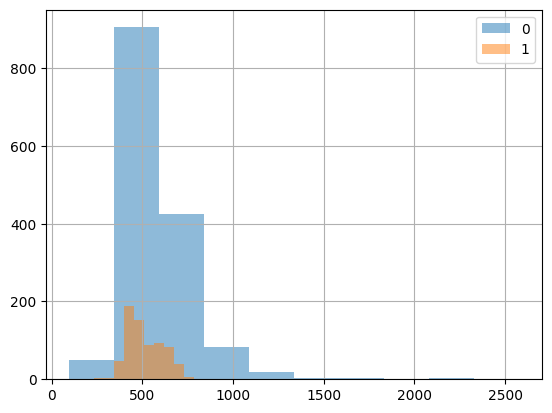

In [37]:
full_df.groupby(['generated']).len.hist(legend=True, alpha=0.5);

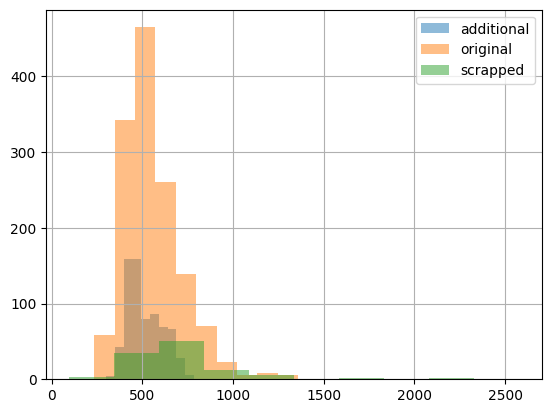

In [38]:
full_df.groupby(['source']).len.hist(legend=True, alpha=0.5);

Распределения длин текстов в оринальном и дополнительном датасете похожи. Это неудивительно, т.к. для получения текстов использовались одинаковые промпты (хотя длина в них в явном виде и не задана). **У эссе, собранных из интернета, длины более разнообразные**, т.к. сам их формат не был жестко задан.

## Frequent words

Посмотрим, отличаются ли по частотным словам (и, следовательно, тематикам) разные части датасета.

In [ ]:
import string

import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
nltk.download('punkt')

stopwords = stopwords.words('english')
stopwords.extend(string.punctuation)
stopwords.extend(['“','”','’','``',"''", "'s", "n't"])

In [ ]:
from collections import Counter
from wordcloud import WordCloud


def tokenize(text):
    return nltk.word_tokenize(text.lower())

def get_all_words(texts):
    all_words = []
    for text in texts:
        words = [word for word in tokenize(text) if word not in stopwords]
        all_words.extend(words)
    return all_words

def find_frequent_words(words, k=20):
    return Counter(words).most_common(k)

def make_wordcloud(texts, figsize=(5.5,4)):
    merged_text = ' '.join(get_all_words(texts))
    wordcloud = WordCloud(background_color="white", collocations=False).generate(merged_text)
    plt.figure(figsize=figsize)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

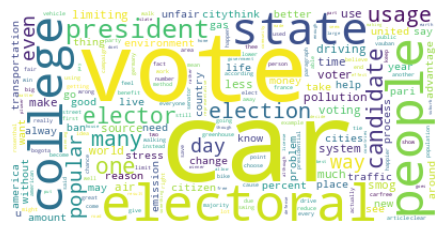

In [47]:
original_words = get_all_words(original_df.text.values)
make_wordcloud(original_words)

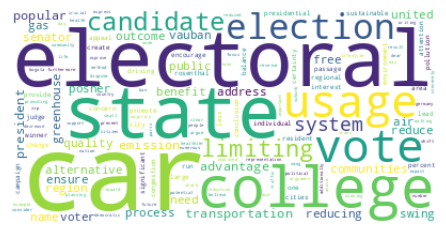

In [48]:
synt_words = get_all_words(synt_df.text.values)
make_wordcloud(synt_words)

Облака слов похожи. Т.к. промпта всего два, все тексты похожи по тематике и частотные слова повторяются от одного текста к другому.

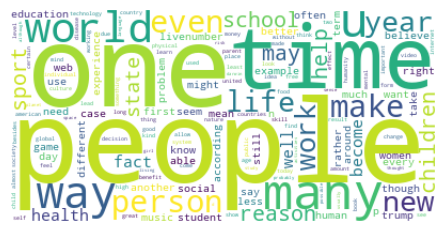

In [49]:
scrapped_words = get_all_words(scrapped_df.text.values)
make_wordcloud(scrapped_words)

**Эссе из интернета более разнообразны по тематикам**, поэтому частотными оказываются более общие понятия (люди, время, мир)

Сравним распределения слов в более явном виде.

In [50]:
frequent_words = pd.DataFrame({
    'original': find_frequent_words(original_words),
    'synt': find_frequent_words(synt_words),
    'scrapped': find_frequent_words(scrapped_words),
    'all': find_frequent_words(get_all_words(full_df.text.values)),
    })
frequent_words

,original,synt,scrapped,all
0,"(electoral, 7234)","(electoral, 5691)","(people, 326)","(electoral, 12928)"
1,"(people, 6922)","(college, 4605)","(one, 303)","(college, 10703)"
2,"(college, 6080)","(states, 3826)","(would, 192)","(car, 9556)"
3,"(vote, 5993)","(car, 3658)","(many, 191)","(states, 7999)"
4,"(car, 5884)","(usage, 2782)","(also, 179)","(vote, 7925)"
5,"(cars, 5730)","(limiting, 2138)","(time, 161)","(people, 7641)"
6,"(states, 4121)","(system, 1916)","(even, 145)","(cars, 7510)"
7,"(would, 3942)","(vote, 1914)","(world, 143)","(usage, 5238)"
8,"(president, 3599)","(cars, 1758)","(person, 142)","(president, 4956)"
9,"(votes, 2536)","(transportation, 1611)","(us, 138)","(would, 4428)"


In [ ]:
def plot_word_freq_distibutions(wordlists: List[str], names: List[str]):
    freqs_dict = {}
    assert len(wordlists) == len(names)
    for wordlist, name in zip(wordlists, names):
         freqs_dict.update({name: [f for w, f in find_frequent_words(wordlist, k=None)]})
    max_length = max(map(len, freqs_dict.values()))
    for name, freqs in freqs_dict.items():
        freqs_dict[name] += [None] * (max_length - len(freqs))
    distr = pd.DataFrame.from_dict(freqs_dict)
    plt.yscale('log')
    sns.lineplot(distr)

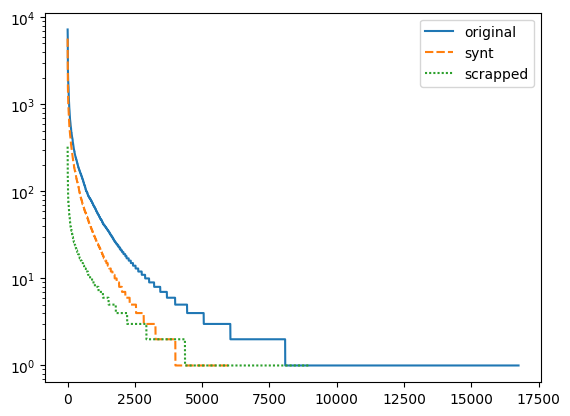

In [52]:
plot_word_freq_distibutions([original_words, synt_words, scrapped_words], ['original', 'synt', 'scrapped'])

## Textstat

Сравним тексты с помощью иблиотеки [textstat](https://github.com/kupolak/textstat).

In [39]:
!pip -q install textstat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 32.5 MB/s eta 0:00:00


In [106]:
import textstat

def count_textstats(df0):
    df = deepcopy(df0)
    df['chars'] = df.text.apply(textstat.char_count)
    df['lexicon'] = df.text.apply(textstat.lexicon_count)
    df['syllables'] = df.text.apply(textstat.syllable_count)
    df['sents'] = df.text.apply(textstat.sentence_count)
    df['avg_sent_len'] = df.text.apply(textstat.avg_sentence_length)
    df['avg_syl_per_word'] = df.text.apply(textstat.avg_syllables_per_word)
    df['avg_letter_per_word'] = df.text.apply(textstat.avg_letter_per_word)
    df['avg_sent_per_word'] = df.text.apply(textstat.avg_sentence_per_word)
    return df

def count_readability(df0):
    df = deepcopy(df0)
    df['fres'] = df.text.apply(textstat.flesch_reading_ease)
    df['fkgl'] = df.text.apply(textstat.flesch_kincaid_grade)
    df['smog'] = df.text.apply(textstat.smog_index)
    df['ari'] =  df.text.apply(textstat.automated_readability_index)
    df['dcrs'] = df.text.apply(textstat.dale_chall_readability_score)
    df['difficult_words'] = df.text.apply(textstat.difficult_words)
    df['lwf'] = df.text.apply(textstat.linsear_write_formula)
    df['gf'] = df.text.apply(textstat.gunning_fog)
    df['smog'] = df.text.apply(textstat.smog_index)
    return df

In [ ]:
from math import ceil

def compare_distibutions(grouped_df, features, num_cols=3, figsize=(10, 9), pad=1):
    fig, ax = plt.subplots(ceil(len(features) / 3), num_cols, figsize=figsize, squeeze=False)
    for i, feature in enumerate(features):
        row = i // num_cols
        col = i % num_cols
        grouped_df[feature].hist(ax = ax[row, col], alpha=0.5)
        ax[row, col].set_title(feature)
    fig.legend(grouped_df.groups.keys())
    fig.tight_layout(pad=1)
    plt.show()

## Text statistics (num chars, syllables, words, etc.)

In [107]:
textstats_df = count_textstats(full_df)

In [108]:
textstats_df.corr().generated

<ipython-input-108-dd062deaadfd>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  textstats_df.corr().generated


prompt_id              0.014095
generated              1.000000
len                   -0.157622
chars                  0.098277
lexicon               -0.156313
syllables              0.105696
sents                 -0.227367
avg_sent_len           0.093440
avg_syl_per_word       0.831033
avg_letter_per_word    0.859947
avg_sent_per_word     -0.173792
Name: generated, dtype: float64

Сгенерированные тексты обозначены за 1. Т.к. есть высокая корреляция с `avg_syl_per_word` и `avg_letter_per_word`, можно сделать вывод о том, что в сгенерированных текстах слова длиннее.

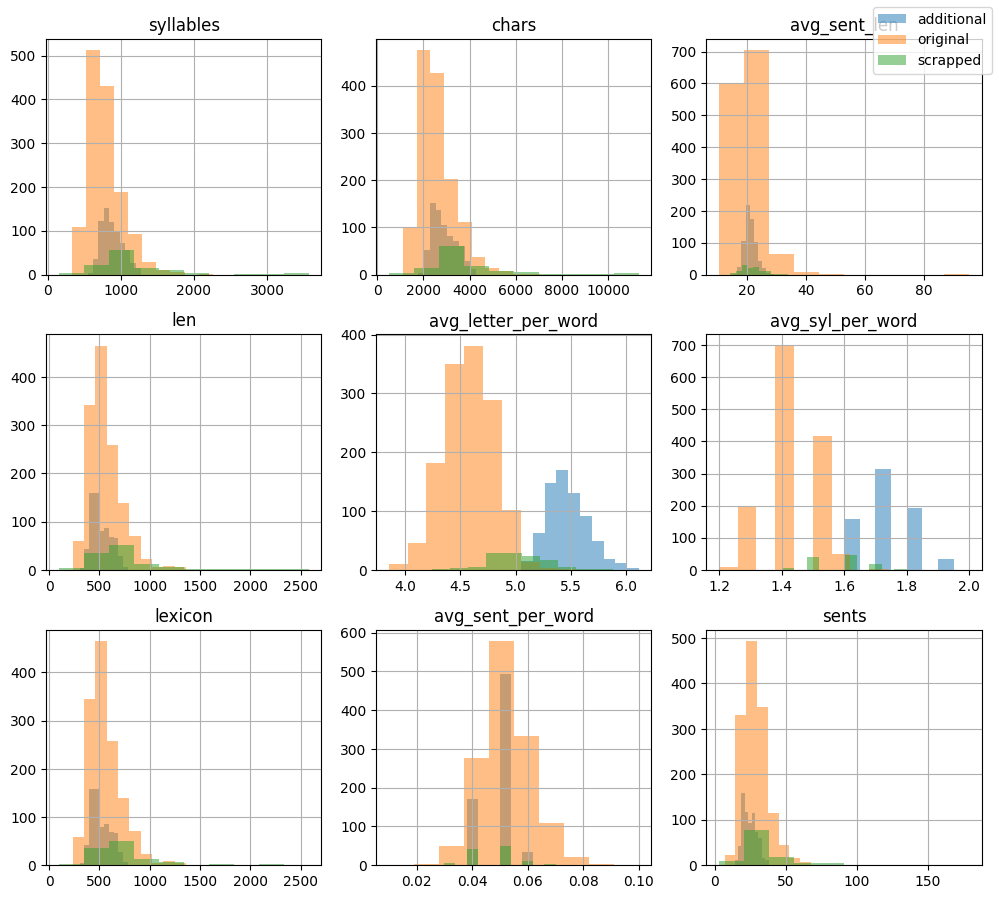

In [111]:
features = set(textstats_df.columns) - {'id', 'prompt_id', 'text', 'generated', 'source', 'title'}
compare_distibutions(textstats_df.groupby('source'), features)

Кроме упомянутой выше разницы для `avg_syl_per_word` и `avg_letter_per_word`, можно обратить внимание на признак `lexicon` (число уникальных слов). Для текстов из интернета он больше всего. Это можно объяснить более разнообразным тематическим содержанием датасета. Кроме того, он больше для оригианльного датасета, чем для синтетического, т.е. **у текстов, написанных людьми, более широкий словарный состав**.

## Readability

In [41]:
readability_df = count_readability(full_df)

In [42]:
readability_df.corr().generated

<ipython-input-42-dd062deaadfd>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  textstats_df.corr().generated


prompt_id          0.014095
generated          1.000000
len               -0.157622
fres              -0.801921
fkgl               0.664877
smog               0.780448
ari                0.672454
dcrs               0.703196
difficult_words    0.559968
lwf                0.546131
gf                 0.604528
Name: generated, dtype: float64

У большинства метрик сложности текста довольно сильная корреляция с таргетом. Т.к.все метрики (кроме FRES), тем больше, чем менее читаем текст, можно сделать вывод о том, что **сгенерированные тексты менее читаемы**. Объясняется это тем, что в таких тестах в среднем используются более длинные слова, как уже было выяснено выше.

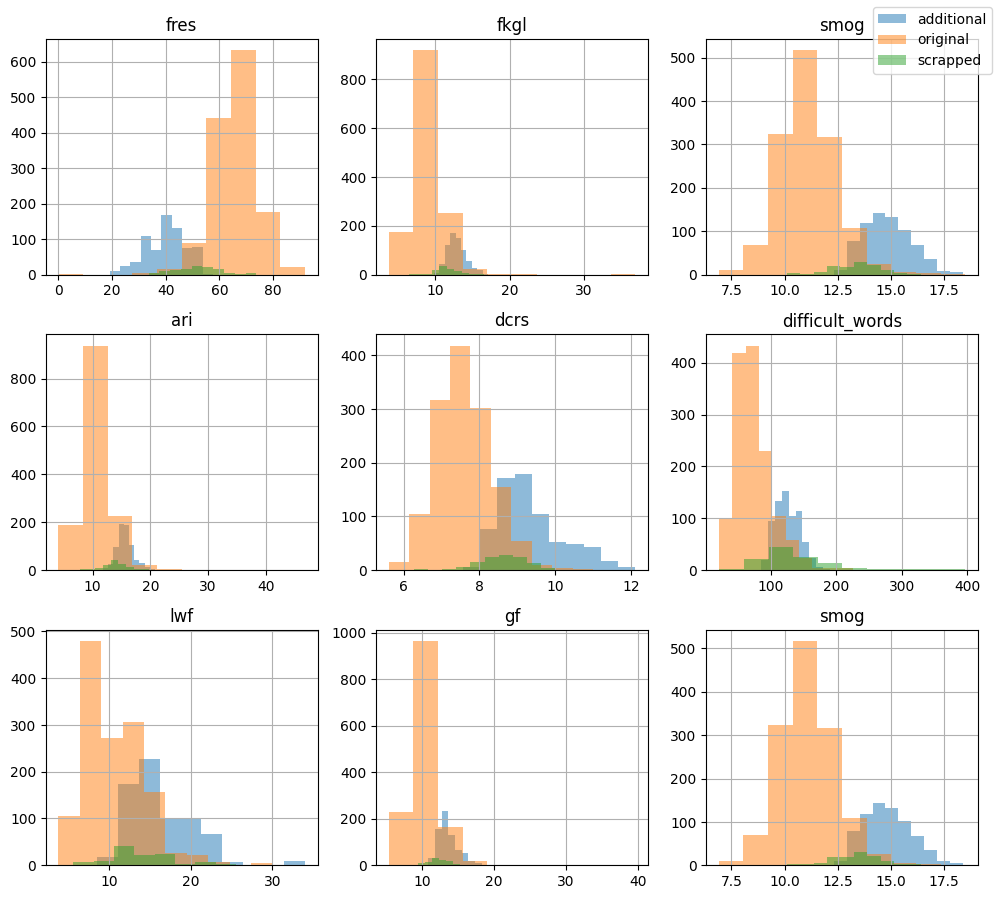

In [90]:
features = set(readability_df.columns) - {'id', 'prompt_id', 'text', 'generated', 'source', 'title', 'len'}
compare_distibutions(readability_df.groupby('source'), features)

Для всех метрик (кроме FRES), распредлеления для синтетического и собранного из интеренета датасетов, находятся правее, чем для оригинального. Т.е. по сложности текстов датасеты соотносятся в следующем порядке: оригинальный (самый простой) - собранный скраппингом - синтетический (самый сложный).